## Case Study 2: A/B Testing for Conversion Rate Optimization
## Table of Contents
- [Overview](#overview)
- [1. Formulating a Hypothesis](#formulating_a_hypothesis)
- [2. Start the Process](#start_the_process)
- [3. Data Cleaning](#data_cleaning)
- [4. Exploratory Data Analysis](#exploratory_data_analysis)
- [5. Testing the Hypothesis](#testing_the_hypothesis)
- [6. Conclusions](#conclusions)

<a id='overview'></a>
## Overview
**Background**

The product team developed a new CTA message and ran an experiment to see if the new message was more effective in getting subscribers to convert.

**Dataset**

I have the experiment result from control and treatment/test group and know that typical conversion rates have historically trended about 10%.

**Goal**

To recommend whether the team should switch to the new message. 

**Approach**

For this case study, I conducted A/B testing and will go through the process from formulating a hypothesis, doing exploratory data analysis, testing the hypothesis, and then interpreting results. 





<a id='formulating_a_hypothesis'></a>
### 1. Formulating a hypothesis

First, let's formulate a hypothesis or two.

We don't know if the new message will result in more, less, or the same conversions as the old message, so we will go with a two-tailed approach. 

The Null hypothesis states that there exists no statistically significant difference in conversion rates between the test (new message) and control (old message) ($H_0$). And the alternative hypothesis states that there exists a statistically significant difference in conversion rates between the test (new message) and control (old message) ($H_a$).

$$H_0: m = m_0$$  
$$H_a: m \ne m_0$$  

where $m$ and $m_0$ stand for the conversion rate of the new and old messages, respectively. If we get a result that shows that the conversion rates are significantly differnt from eachother, we can reject the Null hypothesis.

Let's also set a **confidence level of 95%**:

$$\alpha = 0.05$$

And this is to say that we want to be 95% confident that the conversion rate of the new message is statistically different from the conversion rate of the old message, before we decide to reject the Null hypothesis $H_0$. 

<a id='start_the_process'></a>
### 2. Start the process

Now let's go ahead and install some useful libraries 

In [1]:
#Import statements:

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import sklearn as sk

#For z-tests:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

##### Import the dataset

In [2]:
#Read the data
df = pd.read_csv("/Users/sogolshirazi/Documents/Python Files/Product Analyst _AB Test Data_results_PS.csv")

##### Some stats about the dataset

In [3]:
#Check the first few rows of the data
df.head()

,subscriber_id,timestamp,group,message_version,converted
0,5337528,4/10/2022 23:41:09,test,message_v2,0
1,4899620,4/28/2022 13:40:50,test,message_v2,1
2,4457374,3/21/2022 15:45:06,test,message_v2,0
3,6279421,3/12/2022 17:45:49,control,message_v1,0
4,8124896,3/5/2022 11:46:30,test,message_v2,0


Here, we can see the first few rows of the data and know from our data dictionary that: 

subscriber_id: Unique identifier for a subscriber.


timestamp: The time the message was sent.

group: Describes whether the subscriber was in the test or control group

message_version: Shows version of the message sent

converted: Flag whether the subscriber took action as a result of the message

Our definition of 'converted' is that the subscriber took an action because of the message, but we don't know what that action is. Usually, conversion is purchase, but we don't actually know that here. It could be a click, etc. We can keep this in mind when it comes to interpreting the results.


<a id='data_cleaning'></a>
### 3. Data Cleaning

##### Check for duplicates

In [4]:
# Check for duplicates in subscriber_id
duplicates = df[df.duplicated(subset=['subscriber_id'], keep=False)]
print("Duplicates found in subscriber_id:")
print(duplicates)

Duplicates found in subscriber_id:
       subscriber_id           timestamp    group message_version  converted
24           9243079  3/20/2022 22:56:36     test      message_v2          0
117          8335536   4/23/2022 6:47:21     test      message_v2          0
221          4746202  2/28/2022 11:23:34  control      message_v1          0
630           463680  4/24/2022 20:21:46  control      message_v1          0
1596         5141839  3/19/2022 21:02:09  control      message_v1          0
2483         4746202   4/18/2022 1:21:16     test      message_v2          1
4291          859230  3/23/2022 15:21:05     test      message_v2          0
5188          340742  3/16/2022 17:52:00     test      message_v2          0
5401         1691290    3/4/2022 5:46:25  control      message_v1          0
7153         1723975   3/19/2022 4:43:12     test      message_v2          0
7415         6245314  3/21/2022 15:24:24  control      message_v1          1
7582         6347537    3/2/2022 2:38:37 


I saw that there were some duplicate subscriber_ids in this dataset. I wanted to check the nature of these duplicates to see if all row data was duplicated, or just the subscriber_id. I found that the duplicates were subscribers that had been sent a message twice, sometimes differing messages. At first, I thought about including the data associated with the first message sent for these subscribers, but I realized that too could be influenced by the second message, so I decided to remove all duplicates. You can also remove null values at this step.

##### Remove duplicates

In [5]:
# Remove duplicates based on subscriber_id
df_cleaned = df.drop_duplicates(subset=['subscriber_id'])

# Display the cleaned DataFrame
df_cleaned

,subscriber_id,timestamp,group,message_version,converted
0,5337528,4/10/2022 23:41:09,test,message_v2,0
1,4899620,4/28/2022 13:40:50,test,message_v2,1
2,4457374,3/21/2022 15:45:06,test,message_v2,0
3,6279421,3/12/2022 17:45:49,control,message_v1,0
4,8124896,3/5/2022 11:46:30,test,message_v2,0
...,...,...,...,...,...
19995,8051012,3/26/2022 4:10:16,control,message_v1,0
19996,4630304,3/24/2022 10:25:10,control,message_v1,0
19997,3589638,3/17/2022 9:20:57,test,message_v2,0
19998,6052047,4/8/2022 9:48:57,test,message_v2,0


##### Remove unwanted columns

In [6]:
# Drop unwanted columns
columns_to_drop = ['subscriber_id', 'message_version']  
df_cleaned = df_cleaned.drop(columns=columns_to_drop)
df_cleaned

,timestamp,group,converted
0,4/10/2022 23:41:09,test,0
1,4/28/2022 13:40:50,test,1
2,3/21/2022 15:45:06,test,0
3,3/12/2022 17:45:49,control,0
4,3/5/2022 11:46:30,test,0
...,...,...,...
19995,3/26/2022 4:10:16,control,0
19996,3/24/2022 10:25:10,control,0
19997,3/17/2022 9:20:57,test,0
19998,4/8/2022 9:48:57,test,0


I dropped the subscriber_id column at this point as it did not impact the conversion rate. The message_version was also unnecessary since we already had whether they were in the control vs test group.

##### Other data cleaning

In [7]:
# Ensure the timestamp column is in datetime format
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Extract day of the week and hour of the day from timestamp
df_cleaned['day_of_week'] = df_cleaned['timestamp'].dt.day_name()
df_cleaned['hour_of_day'] = df_cleaned['timestamp'].dt.hour

# Display the updated DataFrame
df_cleaned

,timestamp,group,converted,day_of_week,hour_of_day
0,2022-04-10 23:41:09,test,0,Sunday,23
1,2022-04-28 13:40:50,test,1,Thursday,13
2,2022-03-21 15:45:06,test,0,Monday,15
3,2022-03-12 17:45:49,control,0,Saturday,17
4,2022-03-05 11:46:30,test,0,Saturday,11
...,...,...,...,...,...
19995,2022-03-26 04:10:16,control,0,Saturday,4
19996,2022-03-24 10:25:10,control,0,Thursday,10
19997,2022-03-17 09:20:57,test,0,Thursday,9
19998,2022-04-08 09:48:57,test,0,Friday,9


I thought about looking at the day of the week and hour of the day. I didn't end up using these as variables, but they can be looked at if assessing the impact of the time the messages were sent.

##### General Checks

In [8]:
#Check if categorical variables have appropriate number of levels 
df_cat = df_cleaned[['group','converted', 'day_of_week','hour_of_day']]
df_cat.nunique()

group           2
converted       2
day_of_week     7
hour_of_day    24
dtype: int64

In [9]:
#Check if the categorical variables have appropriate number of levels
for i in df_cat.columns:
    print(i.upper(), ":", df_cat[i].unique())

GROUP : ['test' 'control']
CONVERTED : [0 1]
DAY_OF_WEEK : ['Sunday' 'Thursday' 'Monday' 'Saturday' 'Tuesday' 'Wednesday' 'Friday']
HOUR_OF_DAY : [23 13 15 17 11 14 22 18 19 21  9  0  6  3 16  5 10 12  4  2 20  1  7  8]


<a id='exploratory_data_analysis'></a>
### 4. Exploratory Data Analysis

Let's create a crosstab taking the group column with the converted column (which is our target variable) to start to see what the sample looks like. The data seem fairly normally distributed, but here we can also normalize the data which means we are dividing it by the row totals.

In [10]:
ct_conversion_test_group = pd.crosstab(df_cleaned['group'], df_cleaned['converted'], normalize = 'index')
ct_conversion_test_group

converted,0,1
group,,
control,0.864321,0.135679
test,0.852835,0.147165


We can see here that of the people that saw the control message, 13.6% converted, while of the people that saw the test message, 14.7% converted. Both are already above the typical 10% threshold.

Let's create a visualization for this.

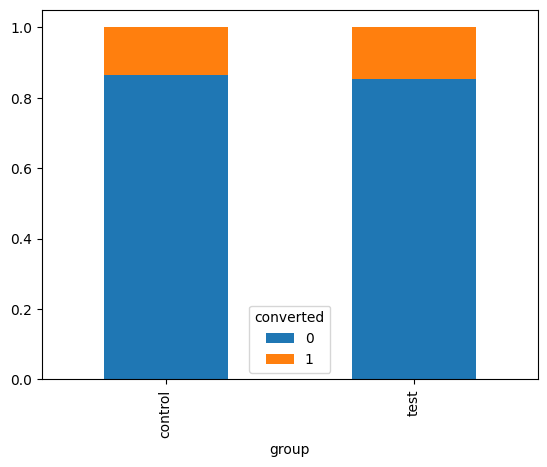

In [11]:
ct_conversion_test_group.plot.bar(stacked=True);

So we can see that, for those that were sent the new message, the conversion rate is higher than those who were sent the old message. But is the difference significant?

I also briefly looked at day of the week to see if there any differences that stood out at-a-glance.

converted           0         1
day_of_week                    
Sunday       0.851794  0.148206
Tuesday      0.855656  0.144344
Friday       0.856259  0.143741
Thursday     0.859155  0.140845
Saturday     0.861581  0.138419
Monday       0.861612  0.138388
Wednesday    0.863458  0.136542


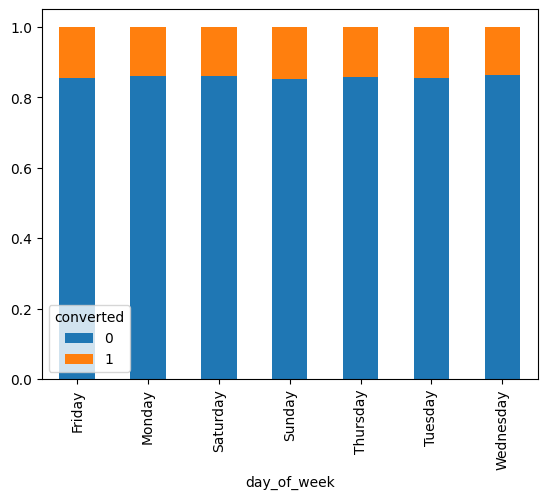

In [12]:
ct_conversion_day = pd.crosstab(df_cleaned['day_of_week'], df_cleaned['converted'], normalize = 'index')
print(ct_conversion_day.sort_values(by=1, ascending=False))
ct_conversion_day.plot.bar(stacked=True);

I didn't end up exploring this avenue further since the focus of this project was more on just the message version impact on conversion rate. 

Going back to looking at conversion rate by test vs control, here we can pull some basic stats like standard deviation and standard error.

In [13]:
conversion_rates = df_cleaned.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']  # Rename columns
conversion_rates

/var/folders/92/qcw5dqq94pd8_gbch38sbhqc0000gn/T/ipykernel_37529/2891492818.py:6: FutureWarning: The provided callable <function mean at 0x103af8e50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.135679,0.342448,0.003419
test,0.147165,0.354271,0.003552


And again we can visualize, this time to see just the difference in conversion rates for the test vs control.

/var/folders/92/qcw5dqq94pd8_gbch38sbhqc0000gn/T/ipykernel_37529/296107176.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x = df_cleaned['group'], y = df_cleaned['converted'], ci=False)


Text(0, 0.5, 'Converted (proportion)')

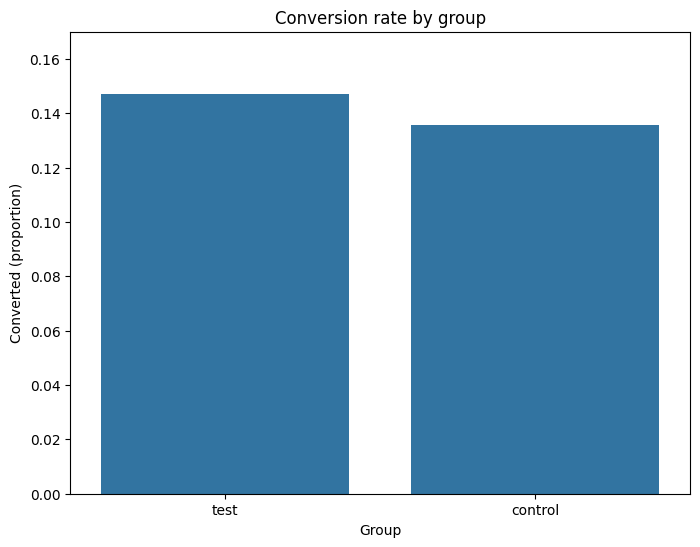

In [14]:
plt.figure(figsize=(8,6))

sns.barplot(x = df_cleaned['group'], y = df_cleaned['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)')

<a id='testing_the_hypothesis'></a>
### 5. Testing the hypothesis

Now that we've cleaned and explored the data, we can go ahead and test our hypothesis. Since the sample is relatively large and normally distributed, we can use a z-test to get the $p$-value and confidence intervals.

In [15]:
control_results = df_cleaned[df_cleaned['group'] == 'control']['converted']
test_results = df_cleaned[df_cleaned['group'] == 'test']['converted']

In [16]:
n_con = control_results.count()
n_test = test_results.count()
successes = [control_results.sum(), test_results.sum()]
nobs = [n_con, n_test]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for test group: [{lower_test:.3f}, {upper_test:.3f}]')

z statistic: -2.33
p-value: 0.020
ci 95% for control group: [0.129, 0.142]
ci 95% for test group: [0.140, 0.154]


<a id='conclusions'></a>
### 6. Conclusions and making recommendations

Since the $p$-value=0.02 is below our $\alpha$=0.05, we can reject the null hypothesis $H_0$, which means that the new message performed significantly better than the old one.

We can look at the confidence interval for the test group ([0.140, 0.154], i.e. 14.0-15.4%) as well as the control group ([0.129, 0.142], i.e. 12.9-14.2%) and we can see that it is higher for the test group, but both groups perform better than the typical 10% conversion rate.

What this means is that the observed difference is unlikely due to chance and that the new message was more effective in getting subscribers to convert.

Should the team switch to the new message? 

The experiment aimed to see if the new CTA message was more effective in getting subscribers to convert compared to the old message. There was a significant difference in the new message compared to the old message in getting subscribers to convert. But there are of course caveats. First, we can go back to defining 'conversions': Did they buy? Did they click? Could it be the case where one message made subscribers click more, while the other ultimately lead to more purchases? It would be helpful to know the metric and know what is the most important metric for the brand.

It would also be helpful to have more information about the subscribers. Are they new subscribers? Are the loyalists? Could then the results be biased by some sort of novelty effect? If there are to be future tests, it would be helpful to know the population.

There will always be caveats, but if team is solely looking to switch messages based on the message's impact on conversion rate in this population, and a conversion rate of 14.7% compared to 13.6% is enough to move the needle, then they should switch to the new message.